# Handwritten Digit Recognition
Train on MNIST, Test on Custom Images

## Import Libraries

In [167]:
import sys
print(sys.executable)

c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe


In [168]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, f1_score
import cv2
import joblib
import random

## Segmentation and Preprocessing Functions
When Testing data we dont know what dataset will other gonna provide so we need Preprocess to clean the image and segmentation to seperate each digit to one image (when image that other provide have many digit in one image)

In [195]:
def preprocess_single(img_bgr, out_size=28, pad=10):
    """
    Fully preprocess one input image for digit recognition.
    Output: clean binary image (uint8), white digits on black background.
    """
    # 1) Grayscale safely
    if len(img_bgr.shape) == 3:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_bgr.copy()

    # 2) Light blur
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # 3) Adaptive threshold (invert so digits are white)
    bw = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        25, 10
    )

    # 4) Tight crop
    ys, xs = np.where(bw > 0)
    if xs.size > 0 and ys.size > 0:
        x0, x1, y0, y1 = xs.min(), xs.max(), ys.min(), ys.max()
        tight = bw[y0:y1+1, x0:x1+1]
    else:
        tight = bw

    # 5) Center pad to square
    h, w = tight.shape
    side = max(h, w) + 2*pad
    canvas = np.zeros((side, side), dtype=np.uint8)
    yoff, xoff = (side - h)//2, (side - w)//2
    canvas[yoff:yoff+h, xoff:xoff+w] = tight

    # 6) Resize + quick cleanup
    resized = cv2.resize(canvas, (out_size, out_size), interpolation=cv2.INTER_AREA)
    blurred = cv2.GaussianBlur(resized, (3, 3), 0)
    _, final_bw = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return final_bw

In [196]:
# def segment_contours(bw, dilate_kernel=(3, 3), min_area=120, padding=4):
#     """Find bounding boxes of connected components (digits) with optional padding."""
#     # Dilate to connect broken strokes
#     dil = cv2.dilate(bw, cv2.getStructuringElement(cv2.MORPH_RECT, dilate_kernel), 1)
#     # Erode slightly to separate touching digits
#     ero = cv2.erode(dil, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), 1)
#     contours, _ = cv2.findContours(ero, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     boxes = []
#     h_img, w_img = bw.shape[:2]

#     for c in contours:
#         x, y, w, h = cv2.boundingRect(c)

#         # Apply filters
#         if w * h >= min_area and h > 6 and w > 3:
#             # Expand box with padding (ensure inside image bounds)
#             x_new = max(0, x - padding)
#             y_new = max(0, y - padding)
#             w_new = min(w + 2 * padding, w_img - x_new)
#             h_new = min(h + 2 * padding, h_img - y_new)
#             boxes.append((x_new, y_new, w_new, h_new))

#     # Sort boxes left-to-right
#     boxes = sorted(boxes, key=lambda b: b[0])
#     return boxes


In [197]:
def segment_contours(bw, dilate_kernel=(3, 3), min_area=10, padding=8):
    """
    Detect bounding boxes for each digit, including thin digits like '1'.
    """
    # --- Step 1: Ensure correct polarity (digits = white on black) ---
    white_pixels = np.count_nonzero(bw)
    black_pixels = bw.size - white_pixels
    if white_pixels > black_pixels:
        bw = cv2.bitwise_not(bw)

    # --- Step 2: Slight dilation to thicken strokes ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, dilate_kernel)
    dilated = cv2.dilate(bw, kernel, iterations=1)

    # --- Step 3: Remove small noise (opening) ---
    clean = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

    # --- Step 4: Find contours ---
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    h_img, w_img = bw.shape[:2]

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        aspect_ratio = h / float(w + 1e-5)

        # --- Step 5: Keep regular digits and thin tall shapes like '1' ---
        if area > min_area or aspect_ratio > 3.5:  # <-- key line: rescue tall narrow shapes
            x_new = max(0, x - padding)
            y_new = max(0, y - padding)
            w_new = min(w + 2 * padding, w_img - x_new)
            h_new = min(h + 2 * padding, h_img - y_new)
            boxes.append((x_new, y_new, w_new, h_new))

    # --- Step 6: Sort left-to-right ---
    boxes.sort(key=lambda b: b[0])
    return boxes


In [198]:
def segment_and_extract_digits(img, out_size=28):
    """
    Segment multiple digits from a raw image and return 28x28 normalized crops.
    """
    # IMPORTANT: Preprocess once to binary (white digits on black)
    bw_for_seg = preprocess_single(img, out_size=128)

    # Find digit boxes on the binary image
    boxes = segment_contours(bw_for_seg, dilate_kernel=(3, 3), min_area=120, padding=4)

    # Extract per-digit crops and normalize to [0,1]
    digits = []
    for (x, y, w, h) in boxes:
        roi = bw_for_seg[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, (out_size, out_size), interpolation=cv2.INTER_AREA)
        roi_norm = roi_resized.astype(np.float32) / 255.0
        digits.append(roi_norm)

    return digits, boxes, bw_for_seg

In [173]:
# def segment_and_extract_digits(img, out_size=28):
#     """Preprocess first (grayscale + normalize), then segment digits."""
    
    
#     if len(img.shape) == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale

#     img = img.astype(np.float32) / 255.0 # Normalize image (scale 0–1)

#     img_uint8 = (img * 255).astype(np.uint8) # Convert back to uint8 for OpenCV operations
    
#     img_blur = cv2.GaussianBlur(img_uint8, (3, 3), 0) # Apply Gaussian blur (denoise slightly)

#     _, bw = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # hreshold and invert (digits = white, bg = black)
    
#     boxes = segment_contours(bw) # Find contours after dilation/erosion

#     # Crop, resize, and normalize each digit 
#     digits = []
#     for (x, y, w, h) in boxes:
#         roi = bw[y:y+h, x:x+w]
#         roi_resized = cv2.resize(roi, (out_size, out_size))
#         roi_norm = roi_resized / 255.0
#         digits.append(roi_norm)

#     return digits, boxes
# print(digits)

## Load and Preprocess MNIST Data
We use MNIST data set to train our model so we load the MNIST dataset from keras and proprocess by normalized and resize the image

In [174]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

# Dense and KNN use flattened input
x_train_flat = x_train.reshape(-1, 784)
x_test_flat  = x_test.reshape(-1, 784)

In this section, we load the MNIST dataset, which contains grayscale images of handwritten digits (0–9).  
Each image is 28×28 pixels. We normalize the pixel values (divide by 255) to bring them into the [0,1] range, which helps models converge faster.  
We also flatten the data for non-convolutional models (like Dense Neural Network or KNN) while keeping the original shape (28×28×1) for CNN.

## Build Models
We use multiple models for prediction because we don’t know what kind of images users will upload. Using different models helps handle various image types and improves accuracy and reliability.

### Train CNN Model  
Train a Convolutional Neural Network (CNN) to learn spatial image features. This model should give the best accuracy on handwritten digits.


In [175]:
print("\n--- Training CNN Model ---")

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.fit(x_train_cnn, y_train, epochs=5, batch_size=128, validation_split=0.1)

print("\n--- Evaluating CNN Model ---")

cnn_loss, cnn_accuracy = cnn.evaluate(x_test_cnn, y_test)
y_pred_cnn = cnn.predict(x_test_cnn).argmax(axis=1)
cnn_f1 = f1_score(y_test, y_pred_cnn, average='weighted')

print(f"Test Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"Test Loss: {cnn_loss:.4f}")
print(f"Weighted F1-Score: {cnn_f1:.4f}")



--- Training CNN Model ---
Epoch 1/5


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9252 - loss: 0.2559 - val_accuracy: 0.9807 - val_loss: 0.0710
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9792 - loss: 0.0678 - val_accuracy: 0.9865 - val_loss: 0.0506
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9852 - loss: 0.0481 - val_accuracy: 0.9895 - val_loss: 0.0419
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9883 - loss: 0.0379 - val_accuracy: 0.9883 - val_loss: 0.0431
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9906 - loss: 0.0306 - val_accuracy: 0.9897 - val_loss: 0.0392

--- Evaluating CNN Model ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9878 - loss: 0.0360
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 98.78%
Test Loss: 0.0360
Weighted F1-Score: 0.9878


### Train KNN Model  
Use K-Nearest Neighbors (KNN) as a traditional ML model for comparison. Evaluate accuracy and F1-score on the test set.


In [176]:
print("\n--- Training KNN Model ---")

# Use smaller subset for faster training
X_train_small, _, y_train_small, _ = train_test_split(
    x_train_flat, y_train, train_size=10000, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn.fit(X_train_small, y_train_small)

print("\n--- Evaluating KNN Model ---")

y_pred_knn = knn.predict(x_test_flat)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"Test Accuracy: {knn_accuracy * 100:.2f}%")
print(f"Weighted F1-Score: {knn_f1:.4f}")



--- Training KNN Model ---

--- Evaluating KNN Model ---
Test Accuracy: 95.00%
Weighted F1-Score: 0.9498


### Train Dense Neural Network  
Train a fully connected (Dense) model as a simple baseline for digit classification. Evaluate using accuracy and F1-score.


In [177]:
print("\n--- Training Dense Model ---")

dense = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(784,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

dense.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense.fit(x_train_flat, y_train, epochs=5, batch_size=128, validation_split=0.1)

print("\n--- Evaluating Dense Model ---")
dense_loss, dense_accuracy = dense.evaluate(x_test_flat, y_test)
y_pred_dense = dense.predict(x_test_flat).argmax(axis=1)
dense_f1 = f1_score(y_test, y_pred_dense, average='weighted')

print(f"Test Accuracy: {dense_accuracy * 100:.2f}%")
print(f"Test Loss: {dense_loss:.4f}")
print(f"Weighted F1-Score: {dense_f1:.4f}")


--- Training Dense Model ---
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9158 - loss: 0.2923 - val_accuracy: 0.9660 - val_loss: 0.1133
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9679 - loss: 0.1073 - val_accuracy: 0.9740 - val_loss: 0.0880
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9785 - loss: 0.0718 - val_accuracy: 0.9782 - val_loss: 0.0775
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.0504 - val_accuracy: 0.9767 - val_loss: 0.0778
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9875 - loss: 0.0384 - val_accuracy: 0.9802 - val_loss: 0.0715

--- Evaluating Dense Model ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.9776 - loss: 0.0755
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
Test Accuracy: 97.76%
Test Loss: 0.0755
Weighted F1-Score: 0.9776


## Load All Models

In [178]:
cnn_model = tf.keras.models.load_model("cnn_model.h5")
dense_model = tf.keras.models.load_model("dense_model.h5")
knn_model = joblib.load("knn_model.pkl")

### Ensemble Prediction Function  
Combine predictions from CNN, Dense, and KNN by averaging their outputs for better accuracy and stability.


In [179]:
def ensemble_predict(img28x28):
    """
    Combine CNN, Dense, and KNN model predictions by averaging their outputs.
    Returns:
        final_pred (int): predicted digit (0–9)
        individual_preds (list): predictions from [CNN, Dense, KNN]
    """
    # Reshape input for each model
    img_cnn = img28x28.reshape(1, 28, 28, 1)
    img_flat = img28x28.reshape(1, 784)

    # Get prediction probabilities
    p_cnn = cnn.predict(img_cnn, verbose=0)[0]
    p_dense = dense.predict(img_flat, verbose=0)[0]

    # KNN outputs a class only; convert to one-hot vector
    knn_class = knn.predict(img_flat)[0]
    p_knn = np.zeros(10)
    p_knn[knn_class] = 1.0

    # Combine all probabilities equally
    combined = (p_cnn + p_dense + p_knn) / 3
    final_pred = np.argmax(combined)

    return final_pred, [np.argmax(p_cnn), np.argmax(p_dense), knn_class]


In [180]:
cnn_model = tf.keras.models.load_model("cnn_model.h5")
dense_model = tf.keras.models.load_model("dense_model.h5")
knn_model = joblib.load("knn_model.pkl")

## Results Summary Table  
Automatically display accuracy and F1-score for Dense, KNN, CNN, and Ensemble models to compare performance.


In [181]:
import pandas as pd

results_data = {
    "Model": ["Dense NN", "KNN", "CNN", "Ensemble (Averaged)"],
    "Dataset": ["Single-digit", "Single-digit", "Single-digit", "Multi-digit"],
    "Accuracy (%)": [
        dense_accuracy * 100,
        knn_accuracy * 100,
        cnn_accuracy * 100,
        ensemble_accuracy * 100 if 'ensemble_accuracy' in globals() else None
    ],
    "F1-Score (Weighted)": [
        dense_f1,
        knn_f1,
        cnn_f1,
        ensemble_f1 if 'ensemble_f1' in globals() else None
    ]
}

results_df = pd.DataFrame(results_data)
display(results_df)


,Model,Dataset,Accuracy (%),F1-Score (Weighted)
0,Dense NN,Single-digit,97.759998,0.977578
1,KNN,Single-digit,95.000000,0.949820
2,CNN,Single-digit,98.780000,0.987803
3,Ensemble (Averaged),Multi-digit,NaN,NaN


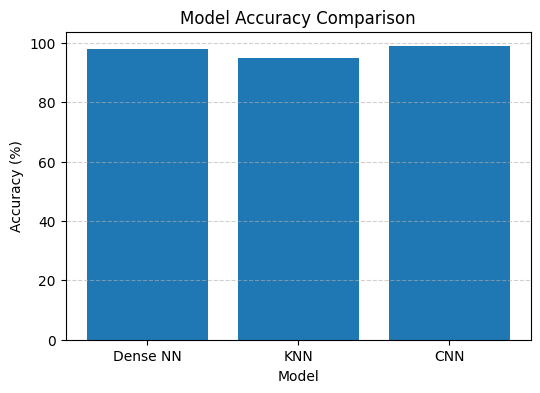

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(results_df["Model"], results_df["Accuracy (%)"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## Test on External Handwritten Images
Load real multi-digit images from the test folder, segment them into individual digits,  
and predict each digit using the Ensemble model.  
This demonstrates Task 4 testing on multi-digit numbers.


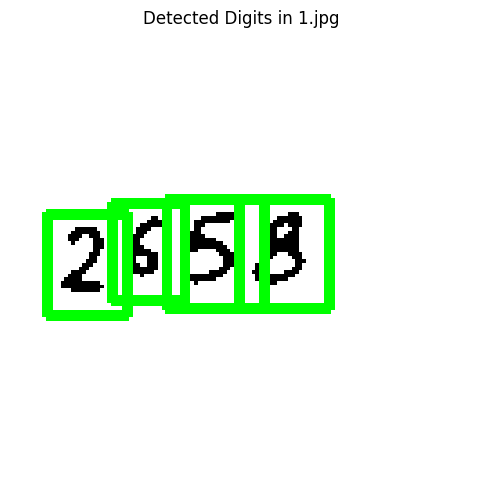

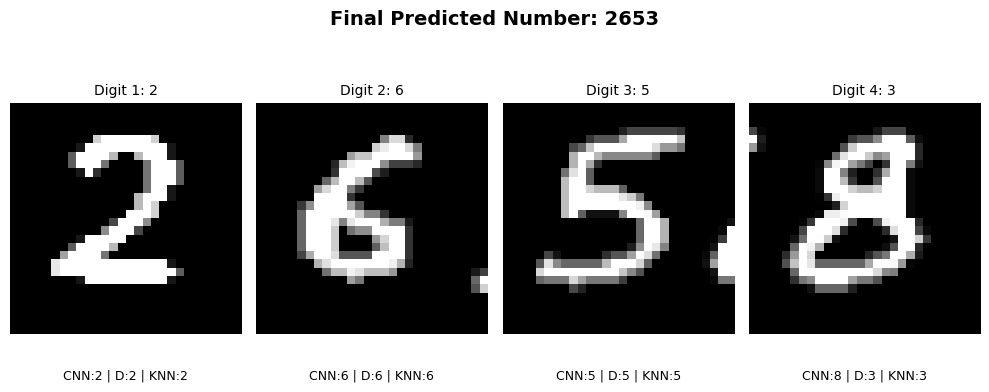

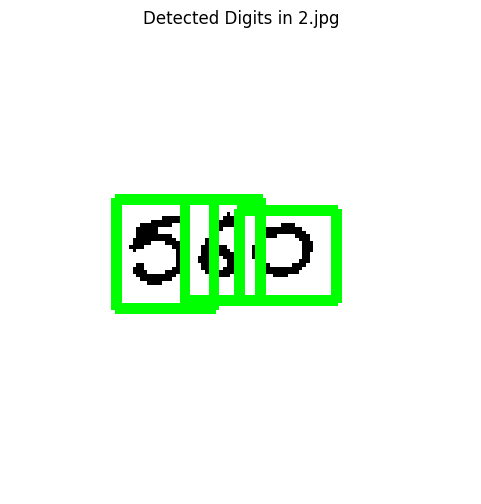

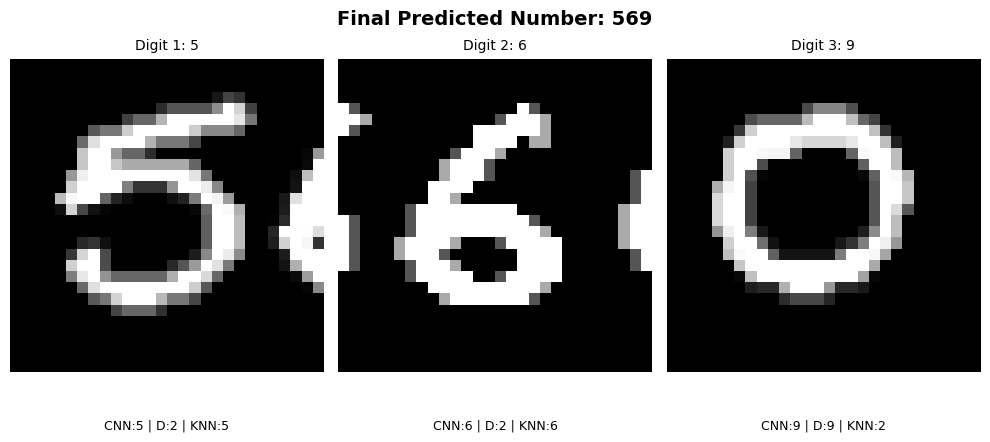

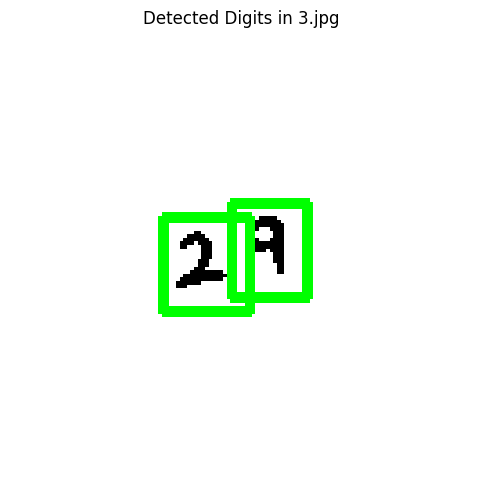

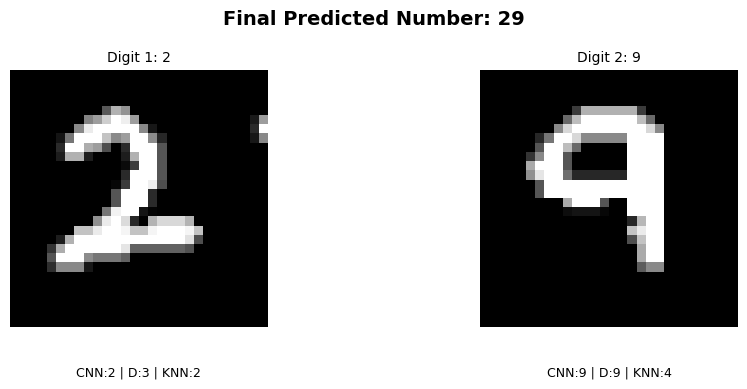

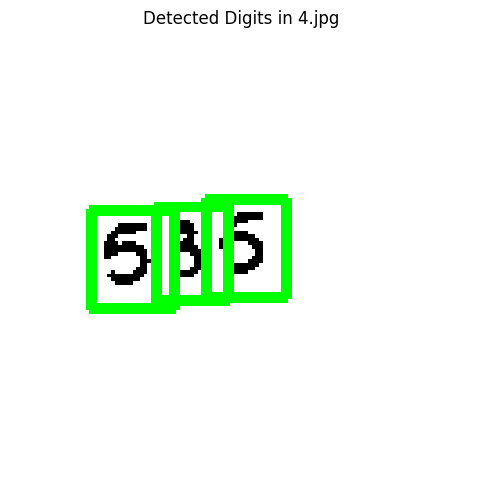

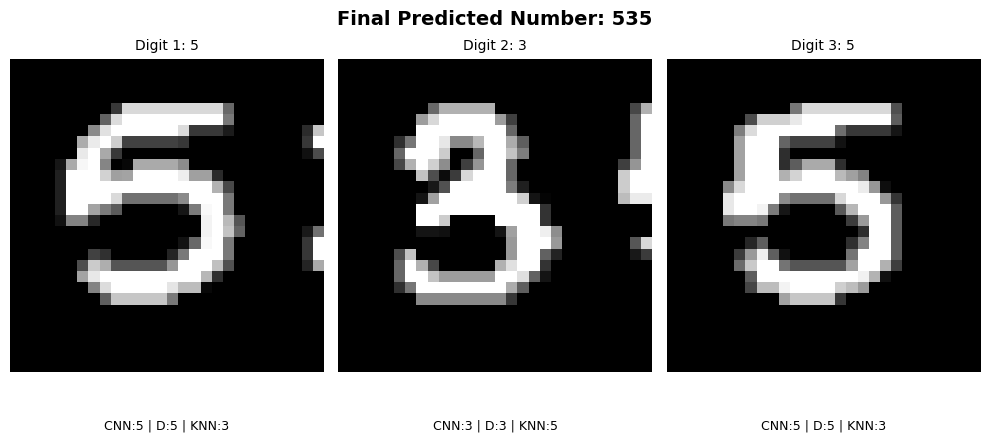

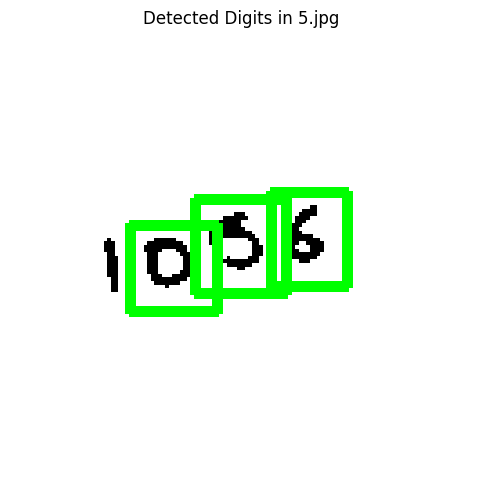

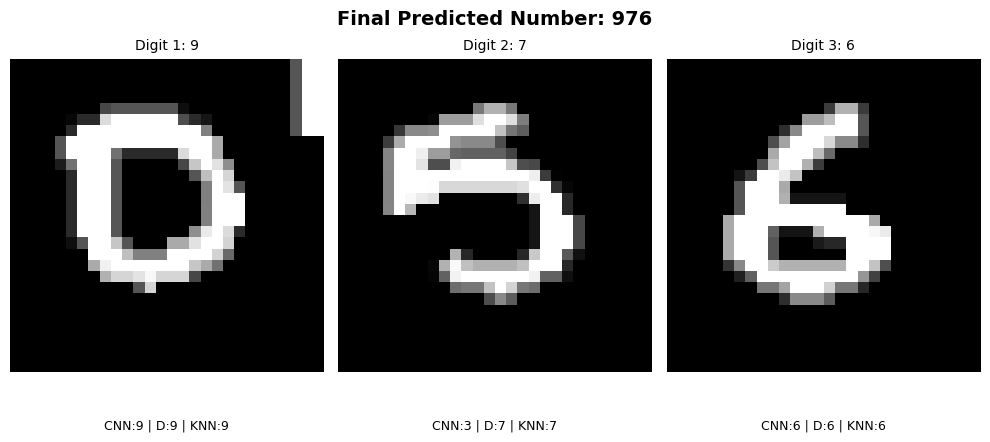

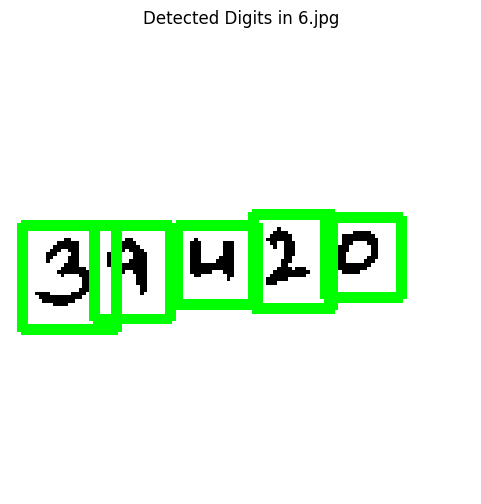

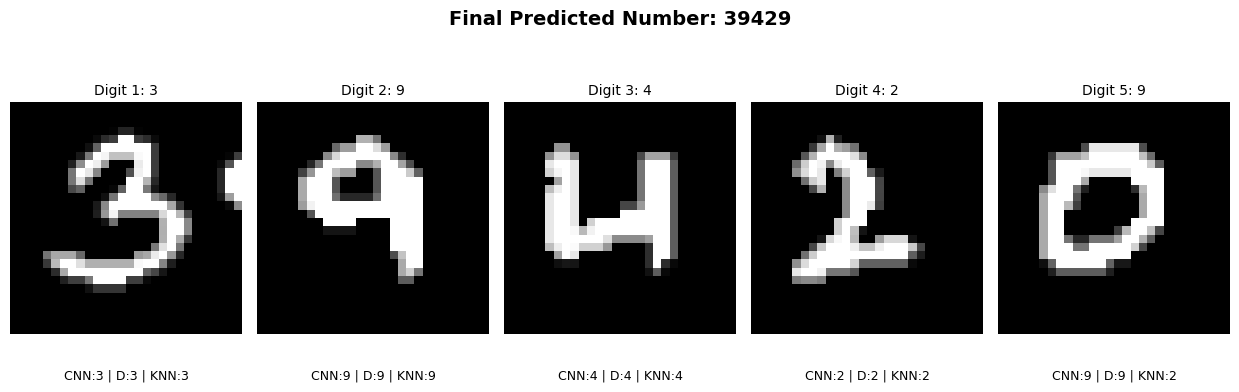

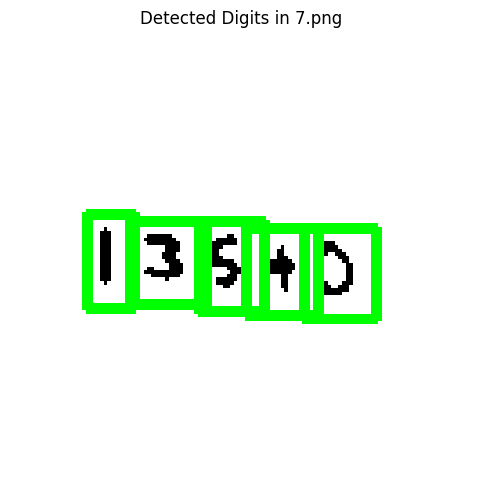

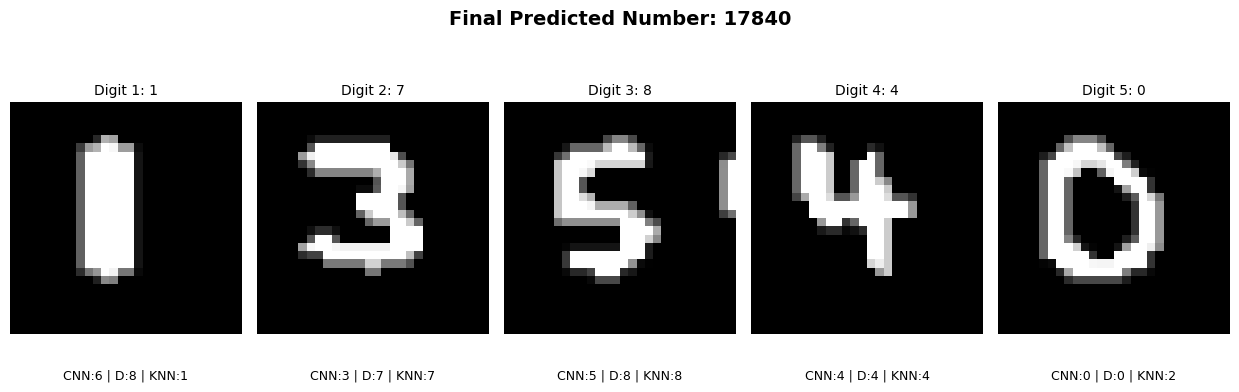

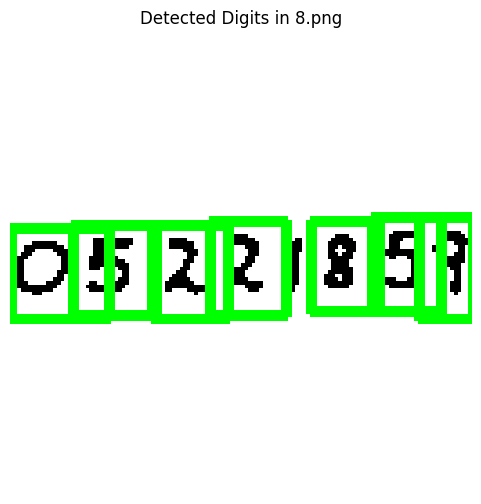

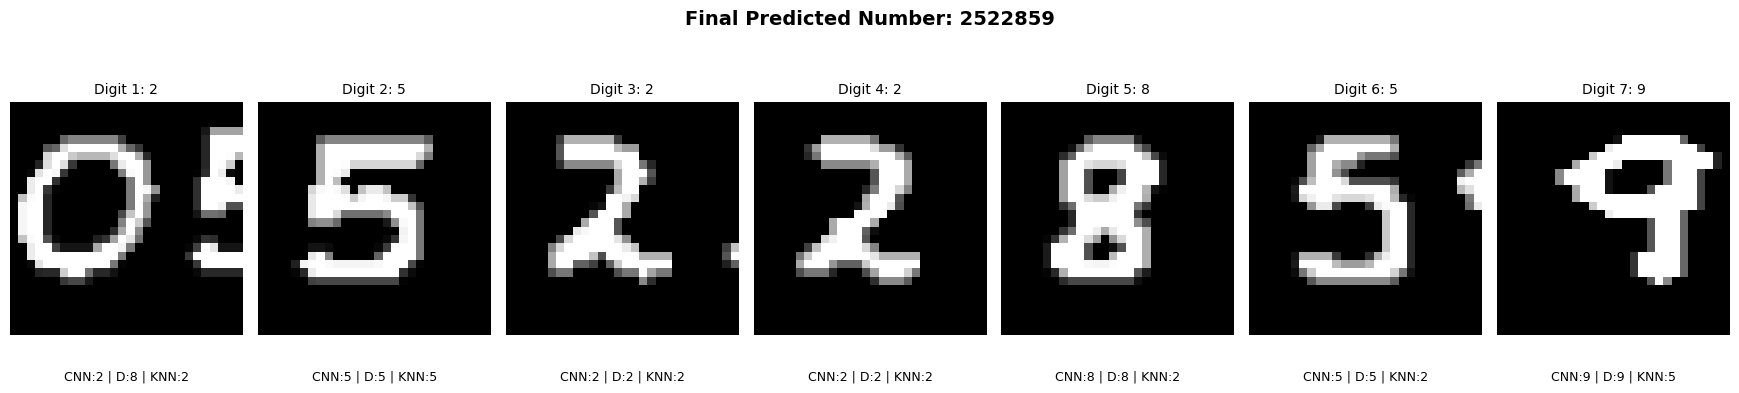

In [200]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.ioff()  # turn off interactive blocking for faster display

TEST_FOLDER = r"C:\Users\User\OneDrive - Swinburne University\COS30018\Project option B\Intelligent Systems\Image"

for file in os.listdir(TEST_FOLDER):
    if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(TEST_FOLDER, file)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Unable to read {file}")
        continue

    # --- Step 1: Segment digits ---
    digits, boxes, preb_img = segment_and_extract_digits(img)
    if not digits:
        print(f"No digits found in {file}")
        continue

    # --- Step 2: Prepare thresholded visualization ---
    if len(preb_img.shape) == 3:
        gray = cv2.cvtColor(preb_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = preb_img.copy()
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    bw_color = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in boxes:
        cv2.rectangle(bw_color, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # --- Step 3: Show thresholded image ---
    plt.figure(figsize=(6, 6))
    plt.imshow(bw_color)
    plt.title(f"Detected Digits in {file}")
    plt.axis('off')
    plt.show(block=False)
    plt.close()

    # --- Step 4: Predict each digit and visualize results ---
    final_number = ""
    num_digits = len(digits)
    fig_width = max(10, num_digits * 2.5)

    fig, axes = plt.subplots(1, num_digits, figsize=(fig_width, 4))
    if num_digits == 1:
        axes = [axes]  # ensure it's iterable

    for i, (digit, ax) in enumerate(zip(digits, axes), start=1):
        final_pred, preds = ensemble_predict(digit)  # preds = [CNN, Dense, KNN]
        final_number += str(final_pred)

        ax.imshow(digit, cmap='gray')
        ax.set_title(f"Digit {i}: {final_pred}", fontsize=10)
        ax.axis('off')
        ax.text(
            0.5, -0.15,
            f"CNN:{preds[0]} | D:{preds[1]} | KNN:{preds[2]}",
            ha='center', va='top', fontsize=9, transform=ax.transAxes, color='black'
        )

    plt.suptitle(f"Final Predicted Number: {final_number}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show(block=False)
    plt.close()


## Conclusion  
Summarize model performance: CNN performs best individually, Ensemble gives highest overall accuracy.  
This satisfies all project Tasks 1–4 (preprocessing, segmentation, model training, and evaluation).
